<h1>The purpose of this notebook is to check which features might be best, i.e., they separate better the data. This is in order to avoid to iterate over all combinations of the features and saving time.
Each point on a plot represents a <b>segment</b>.
<br>
Take these results very carefully for two reasons: we have a total of around 1400 segments, less than 10% of the data we will process, and visual inspection is ok but is no matenatical proof
</h1>

In [8]:
import os, pandas as pd, numpy as np
dforig = pd.read_hdf(os.path.join(os.getcwd(), '..', 'dataset', 'dataset.hdf'))

print("%d segments, %d good, %d outliers" % (len(dforig), len(dforig[dforig['outlier'] == 0]), len(dforig[dforig['outlier'] != 0])))
print('')

dfr = dforig.copy()
# build our pga and pgv features (difference between observed and predicted):
dfr['delta_pga'] = np.log10(dfr['pga_observed'].abs()) - np.log10(dfr['pga_predicted'].abs()) # / dforig['pga_predicted']#.abs()
dfr['delta_pgv'] = np.log10(dfr['pgv_observed'].abs()) - np.log10(dfr['pgv_predicted'].abs()) # / dforig['pgv_predicted']#.abs()

dforig = dfr.copy()

1731185 segments, 333989 good, 1397196 outliers



In [9]:
print('DATAFRAME COLUMNS (our FEATURES): [')
for col in dfr.columns:
    print('    "%s"' % col)
print(']')

print('These are the keys used to denote when we synthetically modified the inventories in order to produce '
      'wrong inventories (list them here for selection purposes afterwards):')
print('modification_types: [')
for col in pd.unique(dfr['modified']):
    print('    "%s"' % col)
print(']')

COLS = [
    'psd@0.1sec',
    'psd@1sec',
    'psd@10sec',
    'psd@20sec',
    'psd@50sec',
    'psd@100sec',
    'amp@0.5hz',
    'amp@1hz',
    'amp@2hz',
    'amp@5hz',
    'amp@10hz',
    'magnitude',
    'distance_km',
    'delta_pga',
    'delta_pgv',
    'snr'
]
print('')
def print_cols(dfr):
    for col in COLS:
        print("%10s %10.2f %10.2f %10.2f" % (col, dfr[col].min(), dfr[col].quantile(0.5), dfr[col].max()))
print_cols(dfr)

DATAFRAME COLUMNS (our FEATURES): [

    "station_id"
    "event_time"
    "amplitude_ratio"
    "snr"
    "magnitude"
    "distance_km"
    "pga_observed"
    "pga_predicted"
    "pgv_observed"
    "pgv_predicted"
    "psd@0.1sec"
    "psd@1sec"
    "psd@10sec"
    "psd@20sec"
    "psd@50sec"
    "psd@100sec"
    "amp@0.5hz"
    "amp@1hz"
    "amp@2hz"
    "amp@5hz"
    "amp@10hz"
    "outlier"
    "modified"
    "Segment.db.id"
    "delta_pga"
    "delta_pgv"
]
These are the keys used to denote when we synthetically modified the inventories in order to produce wrong inventories (list them here for selection purposes afterwards):
modification_types: [
    ""
    "STAGEGAIN:X2.0"
    "STAGEGAIN:X10.0"
    "STAGEGAIN:X100.0"
    "STAGEGAIN:X0.01"
    "STAGEGAIN:X0.1"
    "STAGEGAIN:X0.5"
    "CHARESP:LHZ"
    "CHARESP:LHN"
    "CHARESP:LHE"
    "CHARESP:HHZ"
    "CHARESP:HHN"
    "CHARESP:HHE"
    "CHARESP:BHZ"
    "CHARESP:BHN"
    "CHARESP:BHE"
    "CHARESP:HNZ"
    "CHARESP:HNE"
    

In [5]:
# why so many zeros in amplitudes?
_  = dfr[dfr['snr']>5]
print('min median max for snr>3')
col = 'amp@2hz'
print("%f %f %f" % (_[col].min(), _[col].quantile(0.5), _[col].max()))

_ = _[_['outlier']==0]
print('min median max for not outlier')
col = 'amp@2hz'
print("%f %f %f" % (_[col].min(), _[col].quantile(0.5), _[col].max()))


min median max for snr>3
0.000000 0.000068 981426465934296.125000
min median max for not outlier
0.000000 0.000057 1.008332


In [6]:
# first make amplitudes logarithmic:
for col in [
    'amp@0.5hz',
    'amp@1hz',
    'amp@2hz',
    'amp@5hz',
    'amp@10hz']:
    dfr[col] = np.log10(dfr[col])

/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


In [7]:
print_cols(dfr)

psd@0.1sec   -3076.53    -123.72     305.91
  psd@1sec   -3076.53    -125.99     240.58
 psd@10sec   -3076.53    -134.84      46.94
 psd@20sec   -3076.53    -121.75      13.02
 psd@50sec        nan        nan        nan
psd@100sec        nan        nan        nan
 amp@0.5hz       -inf      -5.18      13.87
   amp@1hz       -inf      -4.99      14.73
   amp@2hz       -inf      -4.91      14.99
   amp@5hz       -inf      -5.00      15.28
  amp@10hz       -inf      -5.12      15.60
 magnitude       0.90       3.30       6.90
distance_km       0.62     233.13     666.07
 delta_pga      -6.84      -0.34      21.14
 delta_pgv      -6.70      -0.15      20.73
       snr       0.00       2.42 5204221.42


In [22]:
# now normalize all columns:
for col in [
        'psd@0.1sec',
        'psd@1sec',
        'psd@10sec',
        'psd@20sec',
        'psd@50sec',
        'psd@100sec',
        'amp@0.5hz',
        'amp@1hz',
        'amp@2hz',
        'amp@5hz',
        'amp@10hz',
        'magnitude',
        'distance_km',
        'delta_pga',
        'delta_pgv']:
    dforig[col] = (dforig[col] - np.nanmin(dforig[col])) / (np.nanmax(dforig[col]) - np.nanmin(dforig[col]))
print_cols()

/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: All-NaN axis encountered


psd@0.1sec       0.00       0.87       1.00
  psd@1sec       0.00       0.89       1.00
 psd@10sec       0.00       0.94       1.00
 psd@20sec       0.00       0.96       1.00
 psd@50sec        nan        nan        nan
psd@100sec        nan        nan        nan
 amp@0.5hz        nan        nan        nan
   amp@1hz        nan        nan        nan
   amp@2hz        nan        nan        nan
   amp@5hz        nan        nan        nan
  amp@10hz        nan        nan        nan
 magnitude       0.00       0.40       1.00
distance_km       0.00       0.35       1.00
 delta_pga       0.00       0.23       1.00
 delta_pgv       0.00       0.24       1.00
       snr       0.00       2.42 5204221.42


In [23]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

PLOT_RATIO = 0.2  # there is too much data, show only this ratio
LOW_SNR = False

def plot(df, col_x, col_y, col_z=None, axis_lim=None):
    '''axis_lim is the quantile of data to be shown on the axis: 0.95 will display the axis min and max
    at 0.05 quantile of the data distribution and 0.95 quantile, respectuvely'''
    if LOW_SNR:
        df = df[df['snr'] > 3]
    df = df[:int(len(df) * PLOT_RATIO)]
    # df = df[(~df['low_snr']) & ~(df['saturated'])]
    df_ok = df[df['outlier']==0]
    df_no = df[df['outlier']!=0]

#     minx, maxx = -0.001, 0.001
#     miny, maxy = -0.00025, 0.00025  ax.set_zlabel('Z')
    
    if axis_lim is None:
        minx, maxx = (df[col_x]).min(), (df[col_x]).max()
        miny, maxy = (df[col_y]).min(), (df[col_y]).max()
        minz, maxz = (None, None)
        if col_z is not None:
            miny, maxy = (df[col_z]).min(), (df[col_z]).max()
    else:
        minx, maxx = df[col_x].quantile([1-axis_lim, axis_lim])
        miny, maxy = df[col_y].quantile([1-axis_lim, axis_lim])
        minz, maxz = (None, None)
        if col_z is not None:
            minz, maxz = df[col_z].quantile([1-axis_lim, axis_lim])

    fig = plt.figure(figsize=(15, 15))

    def newaxes(index):
        row, col = 3, 3
        if col_z is not None:
            ax = fig.add_subplot(row, col, index, projection='3d')
        else:
            ax = fig.add_subplot(row, col, index)
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        ax.set_xlabel(col_x)
        ax.set_ylabel(col_y)
        if col_z is not None:
            ax.set_zlabel(col_z)
            ax.set_zlim(minz, maxz)
        ax.grid(True)
        return ax
    
    def scatter(ax, df, color):
        kwargs = {'edgecolors': 'none', 's': 81}
        if col_z is None:
            ax.scatter(df[col_x], df[col_y], color=color, **kwargs)
        else:
            ax.scatter(df[col_x], df[col_y], df[col_z], color=color, **kwargs)
        
    alpha = 0.1
    
    ax = newaxes(1)
    scatter(ax, df_ok, [0, 0.1, 0.75, alpha])
    ax.set_title('GOOD: %d segs' % len(df_ok))
    
    ax = newaxes(2)
    df_no_ = df_no[df_no['modified'].str.contains('CHARESP')]
    scatter(ax, df_no_, [0.75, 0.1, 0, alpha])
    ax.set_title('BAD (CH.RESP. SWITCH ACC<->VEL): %d segs' % len(df_no_))

    ax = newaxes(3)
    df_no_ = df_no[df_no['modified'].str.contains('INVFILE:')]
    scatter(ax, df_no_, [0, 0.75, 0.1, alpha])
    ax.set_title('BAD (WRONG INVENTORY): %d segs' % len(df_no_))
    
    color = [0.75, 0.5, 0, alpha]

    for i, label in enumerate([
        'STAGEGAIN:X100.0',
        'STAGEGAIN:X10.0',
        'STAGEGAIN:X2.0',
        'STAGEGAIN:X0.01',
        'STAGEGAIN:X0.1',
        'STAGEGAIN:X0.5'
    ], 4):
        ax = newaxes(i)
        df_no_ = df_no[df_no['modified'].str.contains(label)]
        scatter(ax, df_no_, color)
        ax.set_title('BAD (%s): %d segs' % (label, len(df_no_)))
    
#     ax = newaxes(5)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X10.0')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAINx5): %d segs' % len(df_no_))
    
#     ax = newaxes(6)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X2.0')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAINx2): %d segs' % len(df_no_))
    
#     ax = newaxes(7)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X0.1')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAIN/10): %d segs' % len(df_no_))
    
#     ax = newaxes(8)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X0.2')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAIN/5): %d segs' % len(df_no_))
    
#     ax = newaxes(9)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X0.5')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAIN/2): %d segs' % len(df_no_))
    
    space = .4 if col_z is not None else .25
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=space, hspace=space)
    

<h3>First try: PGA vs PGV. Observations on the plots below:
    <ul>
        <li> The symmetry of data along the line y=x (roughly speaking) seems to show that calculations are consistent. Still, you can see how two features separate the data better than a single one (try to project the point on either the x or y axis, and you see that the data blue vs rest is not very separable)
        <li>Changing the gain by a factor of 2,5,10 (bottom plots, yellow) does not change a lot with respect to the good ones (first plot, blue). As expected, the distribution of x10 (first bottom plot on the left) says something more than the other two
    </ul></h3>

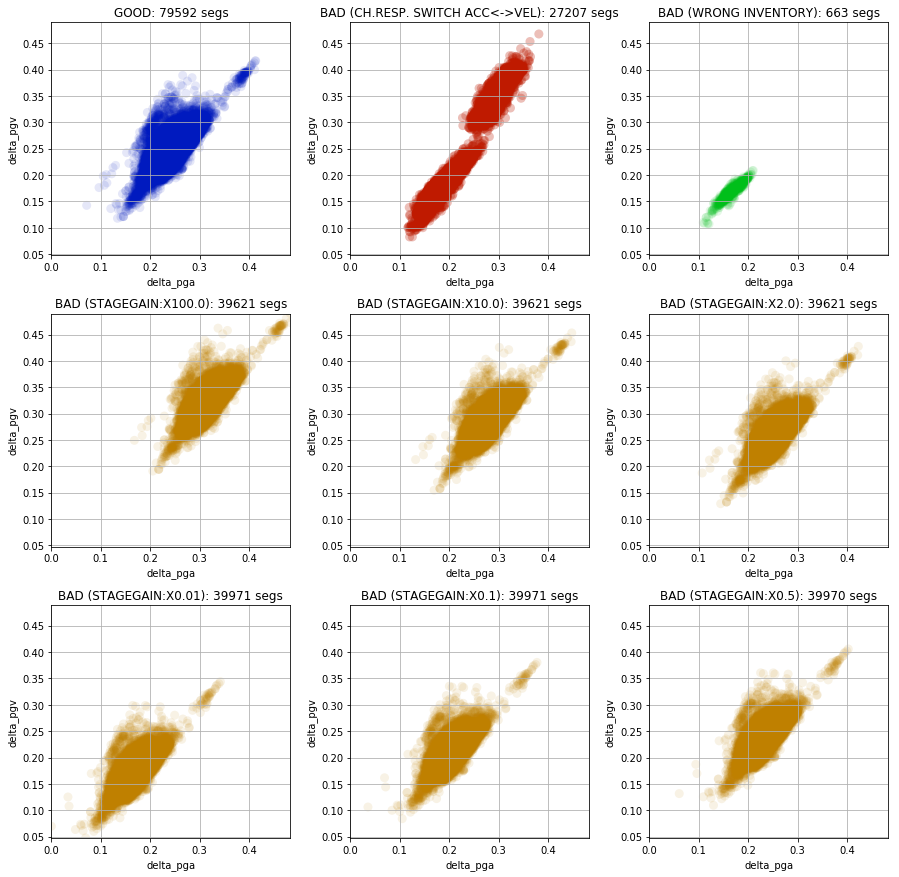

In [16]:
plot(dforig, 'delta_pga', 'delta_pgv', axis_lim=None)

<h3>Ok let's replace PGV with psd@10sec on the y axis. Observations on the plots below:
    <ul>
        <li>psd@10sec seems to well separate the good vs bad data (plots on the first row).
        <li>Still, changing the gain by a factor of 2,5,10 (bottom plots, yellow) does not change a lot with respect to the good ones (first plot, blue)
    </ul>
</h3>

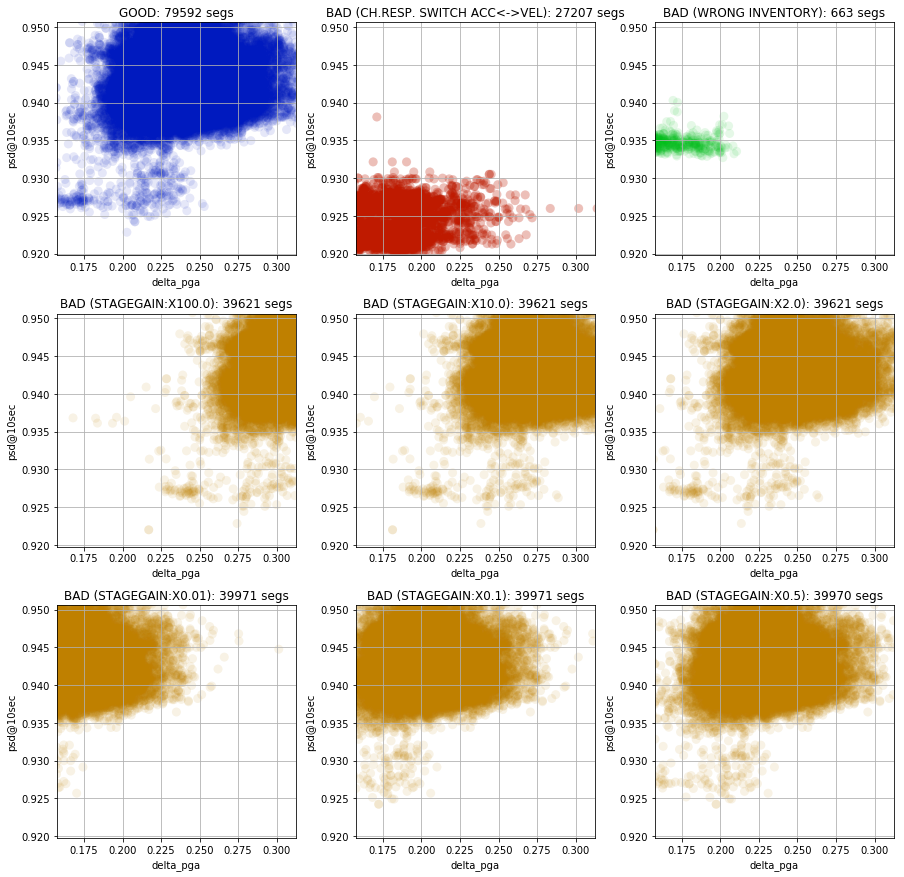

In [17]:
plot(dforig, 'delta_pga', 'psd@10sec', axis_lim=.945)  # with delta_pgv does not change a lot

<h3>What if we add snr?
    <!-- <ul>
        <li>At low periods we have more antropic noise, but apparently if we have a really wrong inventory (first row of plots) psd@0.1sec seem to perform as psd@10sec for good vs bad data (plots on the first row).
        <li>But, changing the gain by a factor of 2,5,10 (bottom plots, yellow) does not change a lot with respect to the good ones (first plot, blue), and in this case psd@10sec performs better
    </ul> -->
</h3>

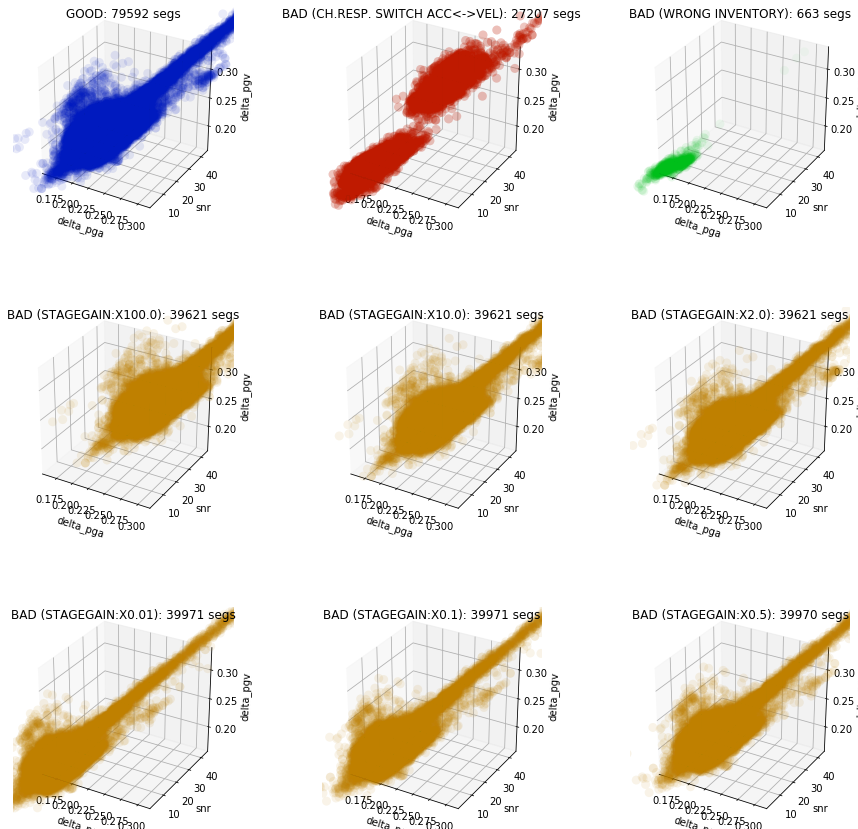

In [25]:
plot(dforig.copy(), 'delta_pga', 'snr', 'delta_pgv', axis_lim=.95)  # with delta_pgv does not change a lot

<h3>What if we use psd@0.1sec (the shortest period we have). Let's replace PGA with psd@0.1sec on the x axis. Observations on the plots below:
    <ul>
        <li>At low periods we have more antropic noise, but apparently if we have a really wrong inventory (first row of plots) psd@0.1sec seem to perform as psd@10sec for good vs bad data (plots on the first row).
        <li>But, changing the gain by a factor of 2,5,10 (bottom plots, yellow) does not change a lot with respect to the good ones (first plot, blue), and in this case psd@10sec performs better
    </ul>
</h3>

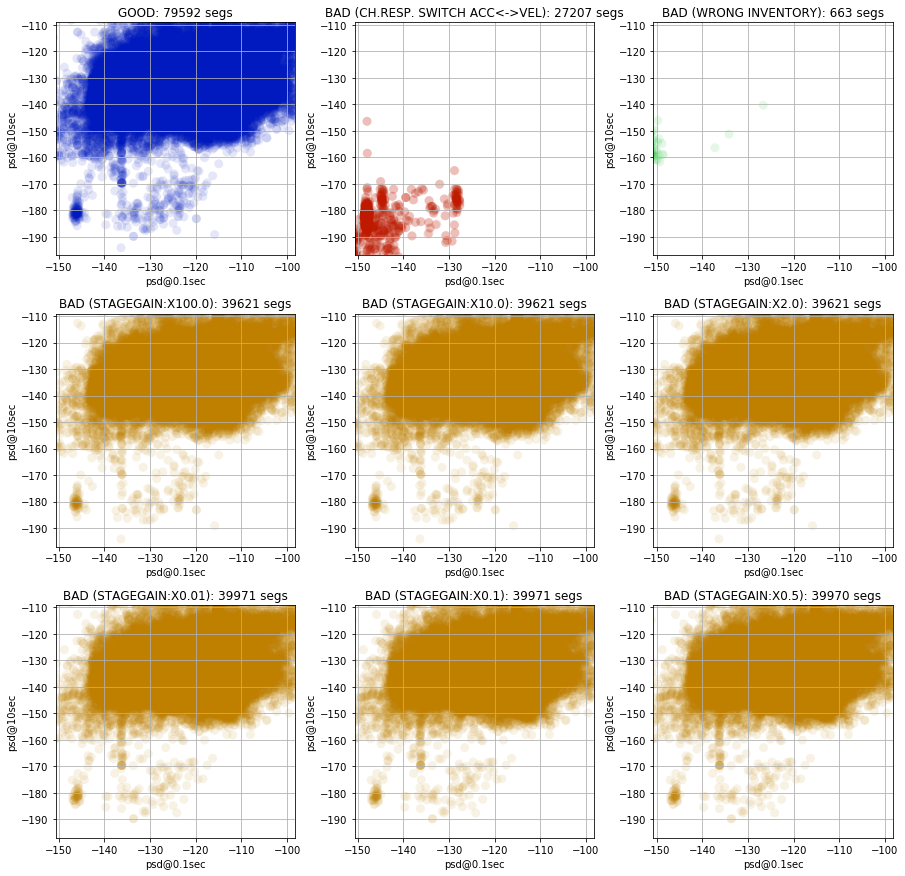

In [16]:
plot(dforig.copy(), 'psd@0.1sec', 'psd@10sec', axis_lim=.94)  # with delta_pgv does not change a lot

<h3>Another try (not shown, irrelevant): let's psd@10sec (the lagest period we have) with some information on the signal (psd refers to the noise). Becasue psd is on the largest period, I take also the amplitude spectrum on the largest frequency (amp@10hz), 
    using the log10 of the amplitudes (Dino observation, ask why) <b>But let's keep in mind that the earthquake amplitude is a function of magnitude and distance</b>, so these plots are just a try. Observations on the plots below:
</h3>

<h3>Last try: let's try to summarize the three most promising features
</h3>

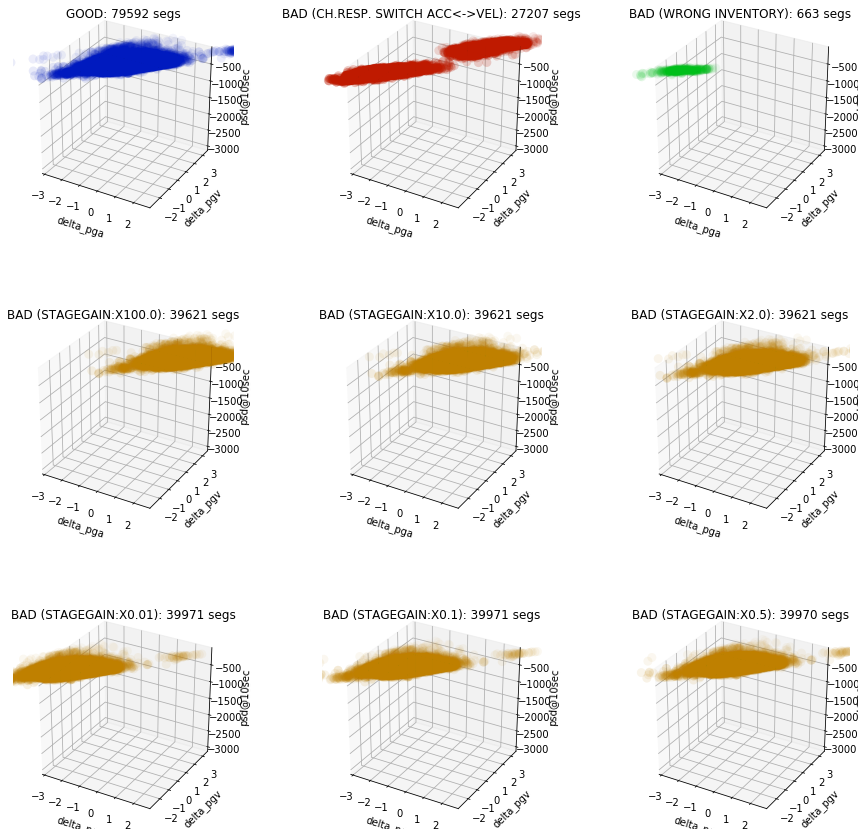

In [17]:
plot(dforig.copy(), 'delta_pga', 'delta_pgv', 'psd@10sec', axis_lim=.99)  # with delta_pgv does not change a lot

In [ ]:
to try:
    1. normalization
    
    2. All combinations:

    delta_pga
    delta_pgv
    psd@10sec
    delta_pga, delta_pgv,
    delta_pga, delta_pgv, psd@10sec,
    delta_pga, psd@10sec, snr
    delta_pga, delta_pgv, snr
    delta_pga, delta_pgv, psd@10sec, snr
    
    then without other info, only spectral information:
    distance_km, magnitude, amp@0.5hz, amp@1hz, amp@2hz, amp@5hz, amp@10hz
    distance_km, magnitude, amp@0.5hz, amp@1hz, amp@2hz, amp@5hz, amp@10hz, snr
    distance_km, magnitude, amp@0.5hz, amp@1hz, amp@2hz, amp@5hz, amp@10hz, psd@10Hz, snr
    
    
    
